In [ ]:
#  %cd /content/drive/MyDrive/ML_Summer2023/Cityscape

/content/drive/MyDrive/ML_Summer2023/Cityscape


In [ ]:
#  !unzip /content/drive/MyDrive/ML_Summer2023/Cityscape/gtFine_trainvaltest.zip

In [ ]:
# import os

# # Specify the folder path
# folder_path = '/content/drive/MyDrive/ML_Summer2023/Cityscape/gtFine/train/zurich'

# # List all files in the folder
# all_files = os.listdir(folder_path)

# # Create a list of image extensions to filter for
# image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp','.json']  # Add more extensions as needed

# # Use a list comprehension to filter image files
# image_files = [file for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]

# # Count the number of image files
# num_images = len(image_files)

# print(f"Number of images in the folder: {num_images}")


Number of images in the folder: 488


In [1]:

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Concatenate,Dropout, UpSampling2D,Reshape
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from glob import glob
from skimage.io import imread
from skimage.transform import resize
import random
from keras.callbacks import ModelCheckpoint
# Tensorflow

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)


# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

Instructions for updating:
non-resource variables are not supported in the long term


2.13.0


In [2]:
def squeeze_excite_block(input, ratio=16):
    # Get the number of channels
    channels = input.shape[-1]

    # Squeeze (Global Average Pooling)
    x = GlobalAveragePooling2D()(input)

    # Excitation
    x = Dense(channels // ratio, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    x = Reshape((1, 1, channels))(x)

    # Scale
    x = multiply([input, x])
    return x

In [3]:


def deeplabv3(input_shape, num_classes):
    #  MobileNetV2
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)


    x = base_model.output
    x = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # ASPP module
    x1 = DepthwiseConv2D(kernel_size=3, strides=1, dilation_rate=6, padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)
    x1 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)

    x2 = DepthwiseConv2D(kernel_size=3, strides=1, dilation_rate=12, padding='same')(x)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)
    x2 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)

    x3 = DepthwiseConv2D(kernel_size=3, strides=1, dilation_rate=18, padding='same')(x)
    x3 = BatchNormalization()(x3)
    x3 = ReLU()(x3)
    x3 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = ReLU()(x3)

    x4 = GlobalAveragePooling2D()(x)
    x4 = Reshape((1, 1, 256))(x4)
    x4 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x4)
    x4 = BatchNormalization()(x4)
    x4 = ReLU()(x4)
    x4 = UpSampling2D(size=(input_shape[0]//32, input_shape[1]//32), interpolation='bilinear')(x4)

    x = Concatenate()([x1, x2, x3, x4])
    x = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(rate=0.5)(x)


    x = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same')(x)
    x = UpSampling2D(size=(input_shape[0]//4, input_shape[1]//4), interpolation='bilinear')(x)


    model = Model(inputs=base_model.input, outputs=x)

    return model



In [4]:
model = deeplabv3(input_shape=(256, 256, 3), num_classes=16)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

Build the model

**[DeepLab](https://github.com/tensorflow/models/tree/master/research/deeplab)** is a state-of-art deep learning model for semantic image segmentation, where the goal is to assign semantic labels (e.g., person, dog, cat and so on):


In the driving context, we aim to obtain a semantic understanding of the front driving scene throught the camera input. This is important for driving safety and an essential requirement for all levels of autonomous driving. The first step is to build the model and load the pre-trained weights. In this demo, we use the model checkpoint trained on [Cityscapes](https://www.cityscapes-dataset.com/) dataset.

<p align="center">
    <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png" width=600></br>
    <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/zuerich00.png" width=600></br>
</p>


In [ ]:
input_shape = (256,256)
num_classes = 16
batch_size = 16
epochs = 50
lr = 1e-4

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='reflect')
val_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/ML_Summer2023/Cityscape/leftImg8bit/train/',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode=None,
    interpolation='bicubic',
    follow_links=True)

train_label_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/ML_Summer2023/Cityscape/gtFine/train',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode=None,
    interpolation='nearest',
    follow_links=True)
train_combined_generator = zip(train_generator, train_label_generator)

val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/ML_Summer2023/Cityscape/leftImg8bit/val',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode=None,
    interpolation='bicubic',
    follow_links=True)

val_label_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/ML_Summer2023/Cityscape/gtFine/val',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode=None,
    interpolation='nearest',
    follow_links=True)

val_combined_generator = zip(val_generator, val_label_generator)

Found 2975 images belonging to 18 classes.
Found 8925 images belonging to 18 classes.
Found 500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('deeplabv3_cityscapes.h5', save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
lrreduce = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

In [ ]:
MODEL = model.fit(train_combined_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=val_combined_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[checkpoint, earlystop, lrreduce])

In [4]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

downloading the sample image...
running deeplab on the sample image...


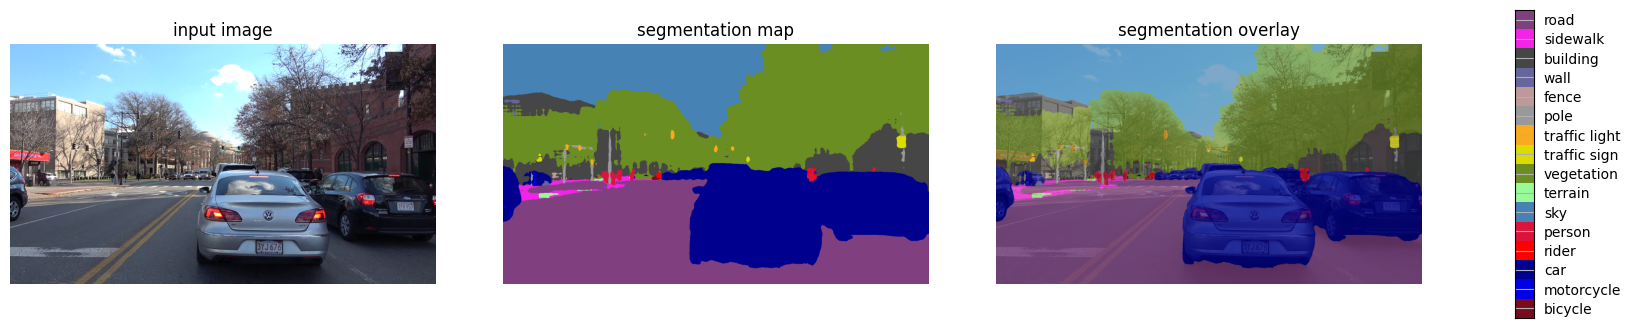

In [6]:
SAMPLE_IMAGE = 'mit_driveseg_sample.png'
if not os.path.isfile(SAMPLE_IMAGE):
    print('downloading the sample image...')
    SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.png?raw=true')[0]
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE)

downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


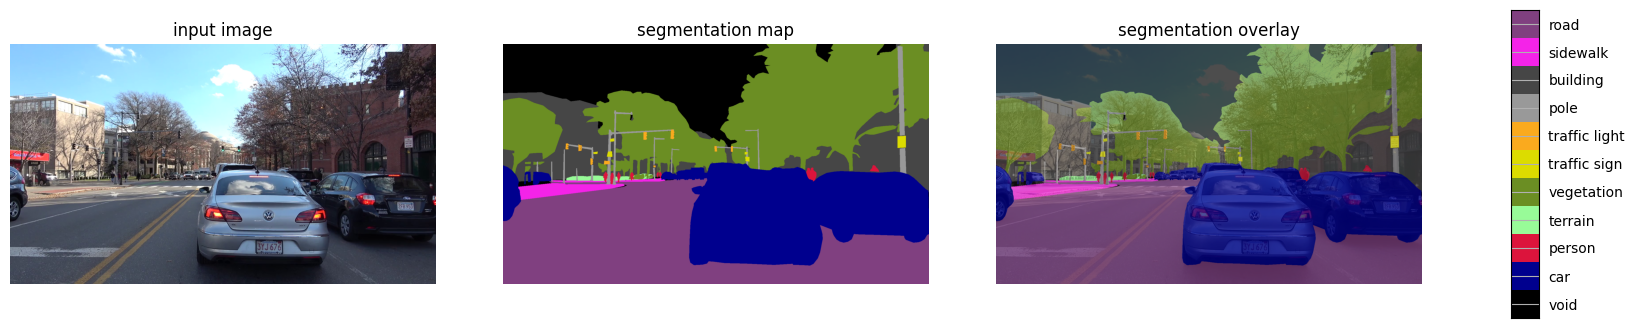

In [7]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()

    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'
if not os.path.isfile(SAMPLE_GT):
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

In [8]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)

    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19],
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703
